In [1]:
import numpy as np
import importlib
import math
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
import scripts.theodolite_utils as tfuu
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import random
random.seed(0)

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
P1 = np.array([[1,0,0,0.5],[0,1,0,-0.25],[0,0,1,0.3],[0,0,0,1]])
P2 = np.array([[1,0,0,-0.1],[0,1,0,0.4],[0,0,1,0.2],[0,0,0,1]])
P3 = np.array([[1,0,0,-0.7],[0,1,0,0],[0,0,1,0.4],[0,0,0,1]])

# Distance in meter
Dist_12 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P2[0,3],P2[1,3],P2[2,3]])),3)
Dist_13 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
Dist_23 = round(np.linalg.norm(np.array([P2[0,3],P2[1,3],P2[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)

In [3]:
tfuu = importlib.reload(tfuu)
# Trajectories simulator (3D)
# Timestamps
begin = 0  #s
end = 60  #s               
rate = 1000  #Hz           
t = np.arange(begin, end, 1/rate)
xt = np.arange(len(t))

# Speed functions
# Traj 1
#speed_linear = np.ones_like(xt)
speed_linear = np.sin(t)+1
speed_yaw = np.sin(0.5*t)*0.08
speed_pitch = np.sin(t)*0.01
speed_roll = np.sin(t)*0.01

T_3d, yaw, pitch, roll, x, y, z = tfuu.traj_simulation(t, speed_linear, speed_yaw, speed_pitch, speed_roll)
T_arr = np.array(T_3d)

<IPython.core.display.Javascript object>


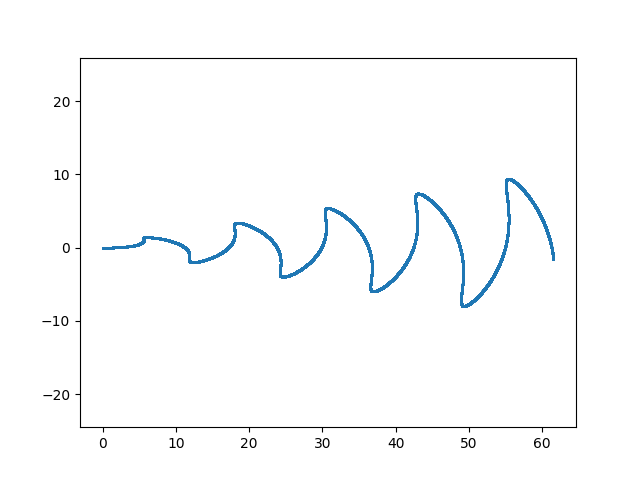

In [4]:
%matplotlib notebook
#plt.plot(t, x, label="x")
#plt.plot(t, y, label="y")
#print(T_arr[:,0,2])
plt.scatter(T_arr[:,0,3],T_arr[:,1,3], s=1, marker="*")
#plt.scatter(T_arr[:,0,3],T_arr[:,2,3], s=1, marker="*")
#plt.scatter(t,T_arr[:,2,3], s=1, marker="*")
#plt.plot(t,yaw)
#plt.plot(t,pitch)
#plt.plot(t,roll)
#plt.plot(t,speed_yaw)
#plt.plot(t,x)
#plt.plot(t,y)
#plt.legend(loc='best')
plt.axis('equal')
plt.show()

In [5]:
tfuu = importlib.reload(tfuu)

mode = "Sync"  #Async or Sync
mean_e = 0
std_e = 0.004
mean_g = 0
std_g = 0.002
mean_noise_t = 0
std_noise_t = 0.003
rate = 2

P1_ref, P2_ref ,P3_ref, P1_noise, P2_noise, P3_noise, P1_noise_sub, P2_noise_sub , P3_noise_sub, t_sub_1, t_sub_2, t_sub_3, e_noise, t_noise_1, t_noise_2, t_noise_3, t_subref_1, t_subref_2, t_subref_3, P1_wnoise_sub, P2_wnoise_sub, P3_wnoise_sub = tfuu.noise_apply(mode, mean_e, std_e, 
                                                            mean_g, std_g, mean_noise_t, std_noise_t, rate, T_arr, t, P1, P2, P3)

<IPython.core.display.Javascript object>


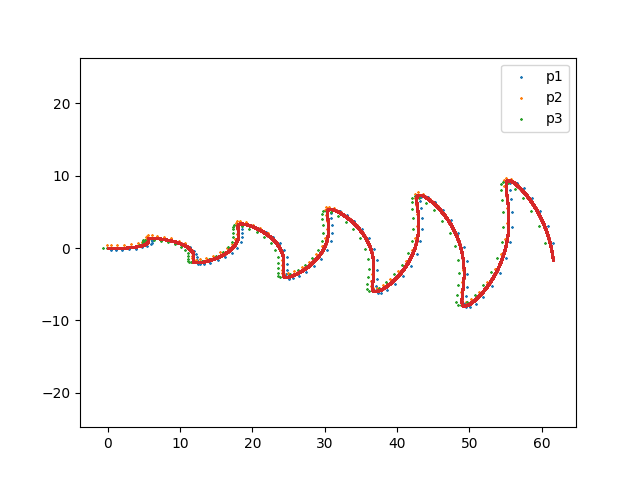

In [6]:
%matplotlib notebook
T_sub_arr_1 = np.array(t_sub_1)
T_sub_arr_2 = np.array(t_sub_2)
T_sub_arr_3 = np.array(t_sub_3)
P1_n_sub = np.array(P1_noise_sub)
P2_n_sub = np.array(P2_noise_sub)
P3_n_sub = np.array(P3_noise_sub)
P1_wnoise_subr = np.array(P1_wnoise_sub)
P2_wnoise_subr = np.array(P2_wnoise_sub)
P3_wnoise_subr = np.array(P3_wnoise_sub)

#plt.scatter(T_sub_arr_1,T_sub_arr_1, marker="*")
#plt.scatter(T_sub_arr_2,T_sub_arr_2, marker="*")
#plt.scatter(T_sub_arr_3,T_sub_arr_3, marker="*")
#plt.scatter(P1_n_sub[:,0],P1_n_sub[:,1], s=1, marker="*", label="p1")
#plt.scatter(P2_n_sub[:,0],P2_n_sub[:,1], s=1, marker="*", label="p2")
#plt.scatter(P3_n_sub[:,0],P3_n_sub[:,1], s=1, marker="*", label="p3")
plt.scatter(P1_wnoise_subr[:,0],P1_wnoise_subr[:,1], s=1, marker="*", label="p1")
plt.scatter(P2_wnoise_subr[:,0],P2_wnoise_subr[:,1], s=1, marker="*", label="p2")
plt.scatter(P3_wnoise_subr[:,0],P3_wnoise_subr[:,1], s=1, marker="*", label="p3")
plt.scatter(T_arr[:,0,3],T_arr[:,1,3], s=1, marker="*")
plt.legend(loc='best')
plt.axis('equal')
plt.show()

In [7]:
d12_ref = []
d13_ref = []
d23_ref = []
for i,j,k in zip(P1_ref, P2_ref ,P3_ref):
    p1 = np.array([i[0],i[1],i[2]])
    p2 = np.array([j[0],j[1],j[2]])
    p3 = np.array([k[0],k[1],k[2]])
    d12_ref.append(round(np.linalg.norm(p1-p2),3))
    d13_ref.append(round(np.linalg.norm(p1-p3),3))
    d23_ref.append(round(np.linalg.norm(p2-p3),3))
    
d12_sub = []
d13_sub = []
d23_sub = []
for i,j,k in zip(P1_wnoise_subr, P2_wnoise_subr ,P3_wnoise_subr):
    p1 = np.array([i[0],i[1],i[2]])
    p2 = np.array([j[0],j[1],j[2]])
    p3 = np.array([k[0],k[1],k[2]])
    d12_sub.append(round(np.linalg.norm(p1-p2),3))
    d13_sub.append(round(np.linalg.norm(p1-p3),3))
    d23_sub.append(round(np.linalg.norm(p2-p3),3))

d12_n = []
d13_n = []
d23_n = []
for i,j,k in zip(P1_noise, P2_noise, P3_noise):
    p1 = np.array([i[0],i[1],i[2]])
    p2 = np.array([j[0],j[1],j[2]])
    p3 = np.array([k[0],k[1],k[2]])
    d12_n.append(round(np.linalg.norm(p1-p2),3))
    d13_n.append(round(np.linalg.norm(p1-p3),3))
    d23_n.append(round(np.linalg.norm(p2-p3),3))

<IPython.core.display.Javascript object>


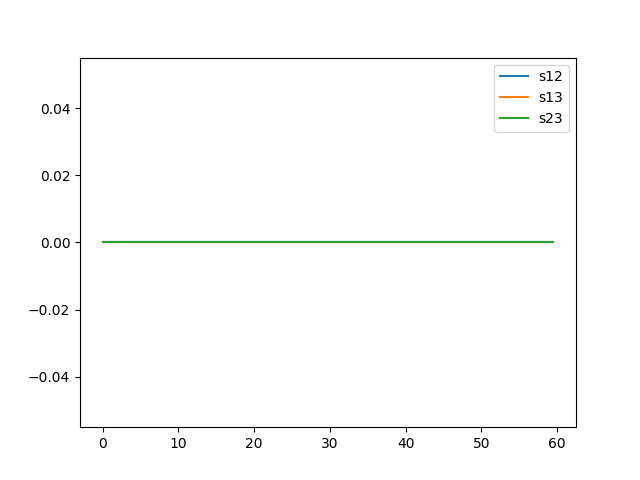

In [8]:
#plt.plot(d12_ref-Dist_12, label = "r12")
#plt.plot(d13_ref-Dist_13, label = "r13")
#plt.plot(d23_ref-Dist_23, label = "r23")
plt.plot(t_subref_1, d12_sub-Dist_12, label = "s12")
plt.plot(t_subref_2, d13_sub-Dist_13, label = "s13")
plt.plot(t_subref_3, d23_sub-Dist_23, label = "s23")
#plt.plot(d12_n-Dist_12, label = "n12")
#plt.plot(d13_n-Dist_13, label = "n13")
#plt.plot(d23_n-Dist_23, label = "n23")
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


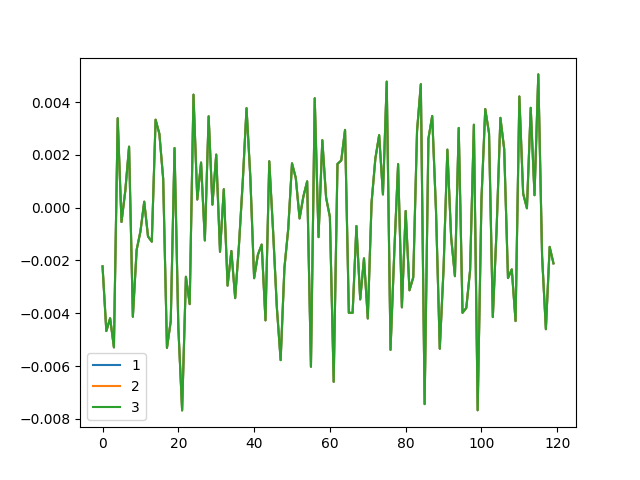

In [9]:
plt.plot(np.array(t_subref_1)-np.array(t_sub_1), label = "1")
plt.plot(np.array(t_subref_2)-np.array(t_sub_2), label = "2")
plt.plot(np.array(t_subref_3)-np.array(t_sub_3), label = "3")
plt.legend(loc='best')
plt.show()

In [10]:
import scripts.theodolite_utils as tfu
tfu = importlib.reload(tfu)
path = "./data/simulation/"
trajectoire = "1"
if(mode=="Sync"):
    mode_s = "sync"
elif(mode=="Async"):
    mode_s = "async"

#Reference pose
tfu.Convert_datapr_to_csv(t, T_arr, path + trajectoire +  "_ref" + ".csv")

# Reference points
tfu.Convert_datap_to_csv(t, P1_ref, path + trajectoire +  "_ref_p_1" + ".csv")
tfu.Convert_datap_to_csv(t, P2_ref, path + trajectoire +  "_ref_p_2" + ".csv")
tfu.Convert_datap_to_csv(t, P3_ref, path + trajectoire +  "_ref_p_3" + ".csv")

# Noise only points
tfu.Convert_datap_to_csv(t, P1_noise, path + trajectoire + "_no_p_1" + ".csv")
tfu.Convert_datap_to_csv(t, P2_noise, path + trajectoire + "_no_p_2" + ".csv")
tfu.Convert_datap_to_csv(t, P3_noise, path + trajectoire + "_no_p_3" + ".csv")

# Subsampling no noises points 
tfu.Convert_datap_to_csv(t_subref_1, P1_wnoise_subr, path + trajectoire + "_s_" + mode_s + "_p_1" + ".csv")
tfu.Convert_datap_to_csv(t_subref_2, P2_wnoise_subr, path + trajectoire + "_s_" + mode_s + "_p_2" +  ".csv")
tfu.Convert_datap_to_csv(t_subref_3, P3_wnoise_subr, path + trajectoire + "_s_" + mode_s + "_p_3" +  ".csv")

# Noise and subsampling points 
tfu.Convert_datap_to_csv(t_sub_1, P1_noise_sub, path + trajectoire + "_ns_" + mode_s + "_p_1" + ".csv")
tfu.Convert_datap_to_csv(t_sub_2, P2_noise_sub, path + trajectoire + "_ns_" + mode_s + "_p_2" +  ".csv")
tfu.Convert_datap_to_csv(t_sub_3, P3_noise_sub, path + trajectoire + "_ns_" + mode_s + "_p_3" +  ".csv")

# Noise saved
tfu.Convert_datane_to_csv(e_noise, path + trajectoire + "_ne_" + mode_s + "_p_1" + ".csv")
tfu.Convert_datant_to_csv(t_noise_1, t_noise_2, t_noise_3, path + trajectoire + "_nt_" + mode_s + "_p_1" + ".csv")

Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
Conversion done !
